In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from openeye import oechem, oedepict, oeomega, oequacpac, oemedchem
from IPython.display import display
import pandas as pd
import oenotebook as oenb
from openmoltools.openeye import get_charges
from openmoltools import openeye
from torsionfit.qmscan.fragment import *
import networkx as nx
from torsionfit.qmscan.enumfrags2pdf import main as vis_wrapper

In [2]:
imatinib = 'C5=C(C1=CN=CC=C1)N=C(NC2=C(C=CC(=C2)NC(C3=CC=C(C=C3)CN4CCN(CC4)C)=O)C)N=C5'
mol = openeye.smiles_to_oemol(imatinib)
charged = get_charges(mol, keep_confs=1)


In [3]:
nilotinib = 'Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)C(=O)Nc4cc(cc(c4)n5cc(nc5)C)C(F)(F)F'
mol = openeye.smiles_to_oemol(nilotinib)
charged = get_charges(mol, keep_confs=1)

In [4]:
disatinib = 'C1=C(SC(=N1)NC2=CC(=NC(=N2)C)N3CCN(CC3)CCO)C(=O)NC4=C(C=CC=C4Cl)C	'
mol = openeye.smiles_to_oemol(disatinib)
charged = get_charges(mol, keep_confs=1)

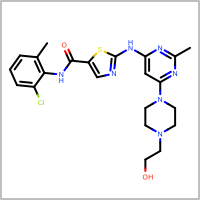

In [5]:
oenb.draw_smiles(disatinib)


In [100]:
def is_hbond(bond):
    hbond = None
    beg = bond.GetBgn()
    end = bond.GetEnd()
    if beg.IsHydrogen() or end.IsHydrogen():
        hbond = bond
    return hbond

def find_ring(a, rot_bond, next_bond, ratoms_l = [], rbonds_l = []):
    if a.GetIdx() not in ratoms_l:
        ratoms_l.append(a.GetIdx())
    for bond in a.GetBonds():
        if bond.IsRotor():
            # I should check for resonance here.
            continue 
        
        if bond.IsInRing() or is_hbond(bond):
            beg = bond.GetBgn()
            end = bond.GetEnd()
            beg_index = beg.GetIdx()
            end_index = end.GetIdx()
            if bond.GetIdx() not in rbonds_l:
                rbonds_l.append(bond.GetIdx())
            if beg_index not in ratoms_l:
                ratoms_l.append(beg_index)
                find_ring(beg, rot_bond, next_bond, ratoms_l, rbonds_l)
            if end_index not in ratoms_l:
                ratoms_l.append(end_index)
                find_ring(end, rot_bond, next_bond, ratoms_l, rbonds_l)
        elif not bond.IsRotor():
            # Keep all constituents that are not rotatable (halogens, o, ch3..)
            beg_idx = bond.GetBgn().GetIdx()
            end_idx = bond.GetEnd().GetIdx()
            if bond.GetIdx() not in rbonds_l:
                rbonds_l.append(bond.GetIdx())
            if beg_idx not in ratoms_l:
                ratoms_l.append(beg_idx)
            if end_idx not in ratoms_l:
                ratoms_l.append(end_idx)  
    return ratoms_l, rbonds_l

def to_AtomBondSet(mol, atoms, bonds):
    AtomBondSet = oechem.OEAtomBondSet()
    for a_idx in atoms:
        AtomBondSet.AddAtom(mol.GetAtom(oechem.OEHasAtomIdx(a_idx)))
    for b_idx in bonds:
        AtomBondSet.AddBond(mol.GetBond(oechem.OEHasBondIdx(b_idx)))
    return AtomBondSet

def is_ortho(bond, rot_bond, next_bond):
    bond_attached = set()
    rot_attached = set()
    next_attached = set()
    # Check if theese bonds have a connecting bond that's in a ring
    beg_b = bond.GetBgn()
    end_b = bond.GetEnd()
    beg_r = rot_bond.GetBgn()
    end_r = rot_bond.GetEnd()
    beg_n = next_bond.GetBgn()
    end_n = next_bond.GetEnd()
    for b in beg_b.GetBonds():
        bond_attached.add(b.GetIdx())
    for b in end_b.GetBonds():
        bond_attached.add(b.GetIdx())        
    for b in beg_r.GetBonds():
        rot_attached.add(b.GetIdx())
    for b in end_r.GetBonds():
        rot_attached.add(b.GetIdx())
    for b in beg_n.GetBonds():
        next_attached.add(b.GetIdx())
    for b in end_n.GetBonds():
        next_attached.add(b.GetIdx())
    intersection = (bond_attached & rot_attached)
    if not bool(intersection):
        # Check if it's ortho to next bond
        intersection = (bond_attached & next_attached)
    return bool(intersection)
    

In [144]:
def build_frag(bond, mol, atoms=set(), bonds=set(), tagged=set(), i=0):
    b_idx = bond.GetIdx()
    if b_idx not in bonds:
        bonds.add(b_idx)
    beg = bond.GetBgn()
    end = bond.GetEnd()
    beg_idx = beg.GetIdx()
    end_idx = end.GetIdx()
    #if beg_idx not in atoms:
    atoms.add(beg_idx)
    iterate_nbratom(beg, mol, bond, beg_idx, end_idx, atoms, bonds, i)
    atoms.add(end_idx)
    iterate_nbratom(end, mol, bond, end_idx, beg_idx, atoms, bonds, i)
    return atoms, bonds

def iterate_nbratom(atom, mol, bond, s_idx, o_idx, atoms, bonds, i):
    for a in atom.GetAtoms():
        a_idx = a.GetIdx()
        next_bond = mol.GetBond(a, atom)
        nb_idx = next_bond.GetIdx()
        if next_bond.GetData('WibergBondOrder') <= 1.2 and i > 0:
            continue
        atoms.add(a_idx)
        if nb_idx != bond.GetIdx() and nb_idx not in bonds:
            bonds.add(nb_idx)
            if a_idx != o_idx:
                if a.IsInRing():
                    r_atoms, r_bonds = find_ring(a, rot_bond=bond, next_bond=next_bond, ratoms_l=[], rbonds_l=[])
                    for a_idx in r_atoms:
                        atoms.add(a_idx)
                    for b_idx in r_bonds:
                        bonds.add(b_idx)
                else:
                    for n_atom in a.GetAtoms():
                        n_idx = n_atom.GetIdx()
                        if n_idx not in (a_idx, s_idx):
                            nn_bond = mol.GetBond(n_atom, a)
                            if nn_bond.GetData('WibergBondOrder') >=1.2:
                                bonds.add(nn_bond.GetIdx())
                                atoms.add(n_idx)
                                i +=1
                                build_frag(nn_bond, mol, atoms, bonds, i=i)
                                
                            if not n_atom.IsCarbon():
                                #functional group
                                atoms.add(n_idx)
                                bonds.add(nn_bond.GetIdx())
                


In [63]:
def build_frag(bond, mol, atoms=set(), bonds=set(), tagged=set(), i=0):
    b_idx = bond.GetIdx()
    if b_idx not in bonds:
        bonds.add(b_idx)
    beg = bond.GetBgn()
    end = bond.GetEnd()
    beg_idx = beg.GetIdx()
    end_idx = end.GetIdx()
    #if beg_idx not in atoms:
    atoms.add(beg_idx)
    print(i)
# put this into a function
    for atom in beg.GetAtoms():
        a_idx = atom.GetIdx()
        next_bond = mol.GetBond(atom, beg)
        nb_idx = next_bond.GetIdx()
        if next_bond.GetData('WibergBondOrder') <= 1.2 and i > 0:
            continue
        atoms.add(a_idx)
        if nb_idx != b_idx and nb_idx not in bonds:
            bonds.add(nb_idx)
            if a_idx != end_idx:
                if atom.IsInRing():
                    r_atoms, r_bonds = find_ring(atom, rot_bond=bond, next_bond=next_bond, atoms=[], bonds=[])
                    for a_idx in r_atoms:
                        atoms.add(a_idx)
                    for b_idx in r_bonds:
                        bonds.add(b_idx)
                else:
                    for n_atom in atom.GetAtoms():
                        n_idx = n_atom.GetIdx()
                        if n_idx not in (a_idx, beg_idx):
                            nn_bond = mol.GetBond(n_atom, atom)
                            if nn_bond.GetData('WibergBondOrder') >=1.2:
                                bonds.add(nn_bond.GetIdx())
                                atoms.add(n_idx)
                                i +=1
                                build_frag(nn_bond, mol, atoms, bonds, i=i)
                                
                            if not n_atom.IsCarbon():
                                #functional group
                                atoms.add(n_idx)
                                bonds.add(nn_bond.GetIdx())
                
    #if end_idx not in atoms:
    atoms.add(end_idx)
    for atom in end.GetAtoms():
        a_idx = atom.GetIdx()  
        next_bond = mol.GetBond(atom, end)
        nb_idx = next_bond.GetIdx()
        if next_bond.GetData('WibergBondOrder') <= 1.2 and i > 0:
            continue
        atoms.add(a_idx)
        if nb_idx != b_idx and nb_idx not in bonds:
            bonds.add(nb_idx)
            if a_idx != beg_idx:
                if atom.IsInRing():
                    r_atoms, r_bonds = find_ring(atom, rot_bond=bond, next_bond=next_bond, atoms=[], bonds=[])
                    for a_idx in r_atoms:
                        atoms.add(a_idx)
                    for b_idx in r_bonds:
                        bonds.add(b_idx)
                else:
                    for n_atom in atom.GetAtoms():
                        n_idx = n_atom.GetIdx()
                        if n_idx not in (a_idx, end_idx):
                            nn_bond = mol.GetBond(n_atom, atom)
                            if nn_bond.GetData('WibergBondOrder') >=1.2:
                                bonds.add(nn_bond.GetIdx())
                                atoms.add(n_idx)
                                i +=1
                                build_frag(nn_bond, mol, atoms, bonds, i=i)
                                
                            if not n_atom.IsCarbon():
                                print(n_atom)
                                #functional group
                                atoms.add(n_idx)
                                bonds.add(nn_bond.GetIdx())
                    
    return atoms, bonds

In [145]:
def wiberg_tagged(mol, wiberg_bond_order=1.2):
    r_tagged = set()
    for bond in charged.GetBonds():
        if not bond.IsInRing():
            if bond.GetData('WibergBondOrder') >= wiberg_bond_order:
                r_tagged.add(bond.GetIdx())
    return r_tagged
                

In [146]:
frags = []
for bond in charged.GetBonds():
    if bond.IsRotor():
        print('rot_bond: {}'.format(bond))
        atoms, bonds = build_frag(bond, charged, atoms=set(), bonds=set())
        atom_bond_set = to_AtomBondSet(charged, atoms, bonds)
        frags.append(atom_bond_set)

rot_bond:  5 (3C-5N)
rot_bond:  6 (5N-6C)
rot_bond: 14 (8C-13N)
rot_bond: 21 (16N-19C)
rot_bond: 22 (19C-20C)
rot_bond: 24 (1C-22C)
rot_bond: 26 (22C-24N)
rot_bond: 27 (24N-25C)


In [147]:
# Convert fragments to smile strings
def frag_to_smiles(frags, mol):
    smiles = []
    for frag in frags:
        fragatompred = oechem.OEIsAtomMember(frag.GetAtoms())
        fragbondpred = oechem.OEIsBondMember(frag.GetBonds())

        fragment = oechem.OEGraphMol()
        adjustHCount = True
        oechem.OESubsetMol(fragment, mol, fragatompred, fragbondpred, adjustHCount)
        smiles.append(oechem.OEMolToSmiles(fragment))
        #print(OEMolToSmiles(fragment))
    return smiles

In [148]:
smiles = frag_to_smiles(frags, charged)

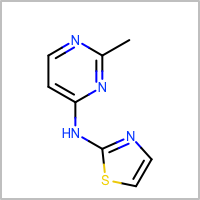

In [149]:
oenb.draw_smiles(smiles[0])

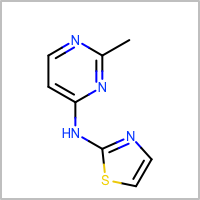

In [150]:
oenb.draw_smiles(smiles[1])

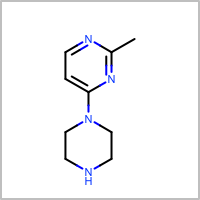

In [151]:
oenb.draw_smiles(smiles[2])

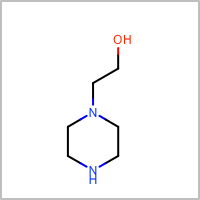

In [152]:
oenb.draw_smiles(smiles[3])

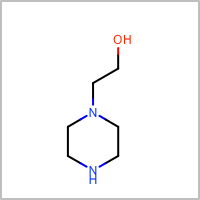

In [153]:
oenb.draw_smiles(smiles[4])

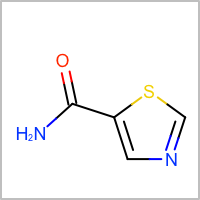

In [154]:
oenb.draw_smiles(smiles[5])

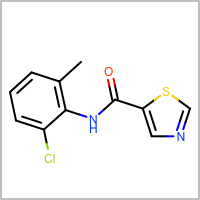

In [155]:
oenb.draw_smiles(smiles[6])

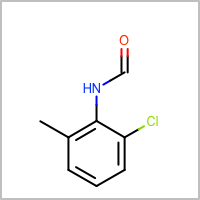

In [156]:
oenb.draw_smiles(smiles[7])

In [143]:
oenb.draw_smiles(smiles[8])

IndexError: list index out of range

In [735]:
def png_atoms_labeled(smiles, mol, fname):
    #test_simple ="c1cc(N)cc(S(=O)(=O)O)c1" 
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, smiles)
    oedepict.OEPrepareDepiction(mol)

    width, height = 300, 200

    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    opts.SetAtomPropertyFunctor(oedepict.OEDisplayAtomIdx())
    opts.SetAtomPropLabelFont(oedepict.OEFont(oechem.OEDarkGreen))

    disp = oedepict.OE2DMolDisplay(mol, opts)
    return oedepict.OERenderMolecule(fname, disp)

In [71]:
oname = 'test5.pdf'
frags_combs = GetFragmentAtomBondSetCombinations(frags)
ToPdf(charged, oname, frags, frags_combs)

0

In [ ]:
"""
ToDo:
1) library of smirks for functional groups - figure out which functinoal groups to include
2) check for resonance for ring constituents
3) write a function to print out all fragments for a molecule
4) Filter out same fragments

Functional groups from organic chem McMurry list
Alkene
Alkyne
Halide
alchohol
ether
monophosphate
anine
imine
nitrile
nitro
thiol
sulfide
disulfide
carbonyl
aldehyde
ketone
carboxylic acid
ester
aminde
caroxylyc acid anhydride
carboxylic acid chloride
"""

In [158]:
fgroups_smarts = {'amide': '[NX3][CX3](=[OX1])[#6]',
                'aldehyde': '[CX3H1](=O)[#6]',
                'alcohol': '[#6][OX2H]'}


In [159]:
fgroups_smarts


{'alcohol': '[#6][OX2H]',
 'aldehyde': '[CX3H1](=O)[#6]',
 'amide': '[NX3][CX3](=[OX1])[#6]'}

In [160]:
mol.GetTitle()

'~{N}-(2-chloro-6-methyl-phenyl)-2-[[6-[4-(2-hydroxyethyl)piperazin-1-yl]-2-methyl-pyrimidin-4-yl]amino]thiazole-5-carboxamide'

In [191]:
fgroup_tagged = {}
for f_group in fgroups_smarts:
    print(f_group)
    qmol = oechem.OEQMol()
    if not oechem.OEParseSmarts(qmol, fgroups_smarts[f_group]):
        print('OEParseSmarts failed')
    ss = oechem.OESubSearch(qmol)
    oechem.OEPrepareSearch(mol, ss)
    #fgroup_tagged[f_group] = []
    for i, match in enumerate(ss.Match(mol, True)):

        fgroup_atoms = []
        for ma in match.GetAtoms():
            fgroup_atoms.append(ma.target) 
            tag = oechem.OEGetTag('fgroup')
            ma.target.SetData(tag, '{}_{}'.format(f_group, str(i)))
        for ma in match.GetBonds()
        fgroup_tagged['{}_{}'.format(f_group, str(i))] = fgroup_atoms

amide
aldehyde
alcohol


In [189]:
for atom in mol.GetAtoms():
    try:
        f_group = atom.GetData()['fgroup']
        # get all atoms from bucket and find bonds between them. Add all atoms and bonds
        
        
    except KeyError:
        pass

In [165]:
def is_fgroup(atom, mol, fgroup_tagged):
    for g in fgroup_tagged:
        l = len(g)
        print(l)

In [192]:
fgroup_tagged

{'alcohol_0': [<oechem.OEAtomBase; proxy of <Swig Object of type 'OEChem::OEAtomBase *' at 0x11fcbfc30> >,
  <oechem.OEAtomBase; proxy of <Swig Object of type 'OEChem::OEAtomBase *' at 0x11fcbfdb0> >],
 'amide_0': [<oechem.OEAtomBase; proxy of <Swig Object of type 'OEChem::OEAtomBase *' at 0x11fcbf090> >,
  <oechem.OEAtomBase; proxy of <Swig Object of type 'OEChem::OEAtomBase *' at 0x11fcbfab0> >,
  <oechem.OEAtomBase; proxy of <Swig Object of type 'OEChem::OEAtomBase *' at 0x11fcbf4e0> >,
  <oechem.OEAtomBase; proxy of <Swig Object of type 'OEChem::OEAtomBase *' at 0x11fcbf660> >]}

In [85]:
oechem.OEPrepareSearch(mol, ss)

In [86]:
f_groups = []
for match in ss.Match(mol, True):
    f_group = []
    for ma in match.GetAtoms():
        f_group.append(ma.target)
    f_groups.append(f_group)
    

In [82]:
for i in f_groups[0]:
    print(i)

IndexError: list index out of range